# Infer ***endoplasmic reticulum*** - part 8️⃣

--------------

## OBJECTIVE:  ✅ Infer sub-cellular component ***endoplasmic reticulum*** (***ER***) in order to understand interactome 



Dependencies:
The ***ER***  inference rely on the cytosol mask.



## IMPORTS

In [1]:
# top level imports
from pathlib import Path
import os, sys
from collections import defaultdict

import numpy as np
from typing import Optional

import aicssegmentation
from aicssegmentation.core.pre_processing_utils import ( intensity_normalization, 
                                                         image_smoothing_gaussian_3d,  
                                                         edge_preserving_smoothing_3d )
from aicssegmentation.core.utils import topology_preserving_thinning, size_filter
from aicssegmentation.core.MO_threshold import MO
from aicssegmentation.core.utils import hole_filling
from aicssegmentation.core.vessel import filament_2d_wrapper, vesselnessSliceBySlice
from aicssegmentation.core.output_utils import   save_segmentation,  generate_segmentation_contour
                                                 
from skimage import filters
from skimage.segmentation import watershed
from skimage.feature import peak_local_max
from skimage.morphology import remove_small_objects, binary_closing, ball , dilation, remove_small_holes   # function for post-processing (size filter)
from skimage.measure import label

# # package for io 
from aicsimageio import AICSImage

import napari

### import local python functions in ../infer_subc_2d
sys.path.append(os.path.abspath((os.path.join(os.getcwd(), '..'))))
from infer_subc_2d.utils.file_io import (read_czi_image, 
                                                                    list_image_files)
from infer_subc_2d.utils.img import *
from infer_subc_2d.constants import (TEST_IMG_N,
                                                                    NUC_CH ,
                                                                    LYSO_CH ,
                                                                    MITO_CH ,
                                                                    GOLGI_CH ,
                                                                    PEROXI_CH ,
                                                                    ER_CH ,
                                                                    LIPID_CH ,
                                                                    RESIDUAL_CH )        

from infer_subc_2d.organelles import fixed_infer_soma, fixed_infer_nuclei, infer_cytosol, find_optimal_Z


%load_ext autoreload
%autoreload 2


test_img_n = TEST_IMG_N

# IMAGE PROCESSING Objective 8:  infer ***ER***
> Back to  [OUTLINE: Objective #5](00_pipeline_setup.ipynb#summary-of-objectives)

## summary of steps

Generally following the Allen Cell Segmenter procedure, but doing more aggressive contrast scaling than their prescribed contrast scaling.

>sec61beta  is  good start for ER  as per from [Allen Cell](https://www.allencell.org/cell-observations/category/endoplasmic-reticulum).    

using [seg_sec61b.py](https://github.com/AllenInstitute/aics-segmentation/blob/master/aics-segmentation/aicssegmentation/structure_wrapper/seg_sec61b.py)
[seg_sec61b_dual.py](https://github.com/AllenInstitute/aics-segmentation/blob/master/aicssegmentation/structure_wrapper/seg_sec61b_dual.py)

[playground_Sec61b.ipynb](https://github.com/AllenInstitute/aics-segmentation/blob/master/lookup_table_demo/playground_Sec61b.ipynb)


### steps

INPUT
- ch 6
- cytosol mask

PRE-PROCESSING
- edge preserving scaling

CORE-PROCESSING
- vesselness slice-by-slice

POST-PROCESSING
  - S  - remove objects less than 2x2 pixels (area = 4)

OUTPUT
- object **er** 




------------------------
# LOAD RAW IMAGE DATA
Identify path to _raw_ image data and load our example image


In [2]:
data_root_path = Path(os.path.expanduser("~")) / "Projects/Imaging/data"

# linearly unmixed ".czi" files are here
data_path = data_root_path / "raw"
im_type = ".czi"

# get the list of all files
img_file_list = list_image_files(data_path,im_type)
test_img_name = img_file_list[test_img_n]

img_data,meta_dict = read_czi_image(test_img_name)

# get some top-level info about the RAW data
channel_names = meta_dict['name']
img = meta_dict['metadata']['aicsimage']
scale = meta_dict['scale']
channel_axis = meta_dict['channel_axis']


/opt/anaconda3/envs/napariNEW/lib/python3.9/site-packages/ome_types/_convenience.py:105: FutureWarning: The default XML parser will be changing from 'xmlschema' to 'lxml' in version 0.4.0.  To silence this warning, please provide the `parser` argument, specifying either 'lxml' (to opt into the new behavior), or'xmlschema' (to retain the old behavior).
  d = to_dict(os.fspath(xml), parser=parser, validate=validate)


## CHOOZE Z-SLICE

Lets find the slice with the most overall intensity...

In [3]:
ch_to_agg = ( LYSO_CH ,
                        MITO_CH ,
                        GOLGI_CH ,
                        PEROXI_CH ,
                        ER_CH ,
                        LIPID_CH )
                            
nuc_ch = NUC_CH
optimal_Z = find_optimal_Z(img_data, nuc_ch, ch_to_agg) 



Now get the single "optimal" slice of all our organelle channels....

In [4]:
img_2D = select_z_from_raw(img_data, optimal_Z)


## Collect the ***cytosol*** mask

i.e. inferred soma, nuclei and cytosol objects
(takes < 1 sec)

In [5]:
soma_mask =  fixed_infer_soma(img_2D) 

nuclei_object =  fixed_infer_nuclei(img_2D, soma_mask) 
cytosol_mask =  infer_cytosol( nuclei_object,soma_mask) 



## Build  ***ER***  specific inference workflow



### INPUT

In [6]:
###################
# INPUT
###################
# raw_er   = img_2D[ER_CH].copy()
raw_er = select_channel_from_raw(img_2D, ER_CH)


### PRE-PROCESSING

In [7]:
###################
# PRE_PROCESSING
###################
struct_img = min_max_intensity_normalization( raw_er)


# edge-preserving smoothing (Option 2, used for Sec61B)
structure_img_smooth = edge_preserving_smoothing_3d(struct_img)
# 10 seconds!!!!  tooooo slow... for maybe no good reason

### CORE PROCESSING

In [8]:
###################
# CORE_PROCESSING
###################

################################
## PARAMETERS for this step ##
f2_param = [[1, 0.15]]
################################

bw = filament_2d_wrapper(structure_img_smooth, f2_param)

### POST-PROCESSING

In [9]:

###################
# POST_PROCESSING
###################
################################
## PARAMETERS for this step ##
small_object_width = 4
################################
er_object = size_filter_2D(bw, 
                                                min_size= small_object_width**2, 
                                                connectivity=1)
# ################################
# ## PARAMETERS for this step ## from seg_sec61b.py
# min_area = 15
# ################################
# bw = remove_small_objects(bw > 0, min_size=min_area, connectivity=1, in_place=False)
# # prune slice by slice
# for zz in range(bw.shape[0]):
#     bw[zz, :, :] = remove_small_objects(bw[zz, :, :], min_size=3, connectivity=1, in_place=False)

# ER_object = remove_small_objects(bw > 0, min_size=min_area, connectivity=1, in_place=False)



#### Visualize with `napari`
Visualize the first-pass segmentation and labeling with `napari`.

In [10]:

viewer = napari.view_image(
    bw,
    scale=scale
)


viewer.scale_bar.visible = True
viewer.add_image(
    structure_img_smooth,
    scale=scale
)

viewer.add_image(
    er_object,
    scale=scale
)

<Image layer 'er_object' at 0x1411fe9d0>

### Collect into a single `infer_endoplasmic_reticulum` function

In [14]:
##########################
#  infer_endoplasmic_reticulum
##########################
def _infer_endoplasmic_reticulum(
                                in_img: np.ndarray,
                                cytosol_mask: np.ndarray,
                                filament_scale : float,
                                filament_cut : float,
                                small_obj_w: int,
                            ) -> np.ndarray:
    """
    Procedure to infer peroxisome from linearly unmixed input.

    Parameters:
    ------------
    in_img: np.ndarray
        a 3d image containing all the channels
    cytosol_mask: np.ndarray
        mask of cytosol
    filament_scale: float
        scale (log_sigma) for filament filter
    filament_cut: float
        threshold for filament fitered threshold
    small_obj_w: int
        minimu object size cutoff for nuclei post-processing
    Returns:
    -------------
    peroxi_object
        mask defined extent of peroxisome object
    """
    er_ch = ER_CH
    ###################
    # EXTRACT
    ###################    
    er = select_channel_from_raw(in_img, er_ch)

    ###################
    # PRE_PROCESSING
    ###################    
    er = min_max_intensity_normalization(er)

    # edge-preserving smoothing (Option 2, used for Sec61B)
    er = edge_preserving_smoothing_3d(er)

   ###################
    # CORE_PROCESSING
    ###################
    # f2_param = [[filament_scale, filament_cut]]
    # # f2_param = [[1, 0.15]]  # [scale_1, cutoff_1]
    # struct_obj = filament_2d_wrapper(er, f2_param)
    struct_obj = filament_filter(er, filament_scale, filament_cut)

    ###################
    # POST_PROCESSING
    ################### 
    struct_obj = apply_mask(struct_obj, cytosol_mask)

    struct_obj = size_filter_2D(struct_obj, 
                                                    min_size= small_obj_w**2, 
                                                    connectivity=1)

    return struct_obj



In [15]:
##########################
#  fixed_infer_endoplasmic_reticulum
##########################
def _fixed_infer_endoplasmic_reticulum(in_img: np.ndarray, 
                                                cytosol_mask: Optional[np.ndarray] = None
                                            ) -> np.ndarray:
    """
    Procedure to infer endoplasmic rediculum from linearly unmixed input with *fixed parameters*

    Parameters:
    ------------
    in_img: np.ndarray
        a 3d image containing all the channels
    cytosol_mask: Optional[np.ndarray] = None
        mask

    Returns:
    -------------
    peroxi_object
        mask defined extent of peroxisome object
    """
    filament_scale = 1
    filament_cut = 0.15
    small_obj_w = 2 
    return _infer_endoplasmic_reticulum(  in_img,
                                cytosol_mask,
                                filament_scale,
                                filament_cut ,
                                small_obj_w)
    
    

# TEST  `_infer_endoplasmic_reticulum` function

In [16]:

_er_object =  _fixed_infer_endoplasmic_reticulum(img_2D, cytosol_mask) 


In [17]:
from infer_subc_2d.organelles import fixed_infer_endoplasmic_reticulum

er_object =  fixed_infer_endoplasmic_reticulum(img_2D, cytosol_mask) 


In [24]:

viewer.add_image(
    er_object,
    scale=scale
)
viewer.add_labels(
    label(er_object),
    scale=scale
)


viewer.add_image(
    _er_object,
    scale=scale
)

<Image layer '_er_object' at 0x18c2a4af0>

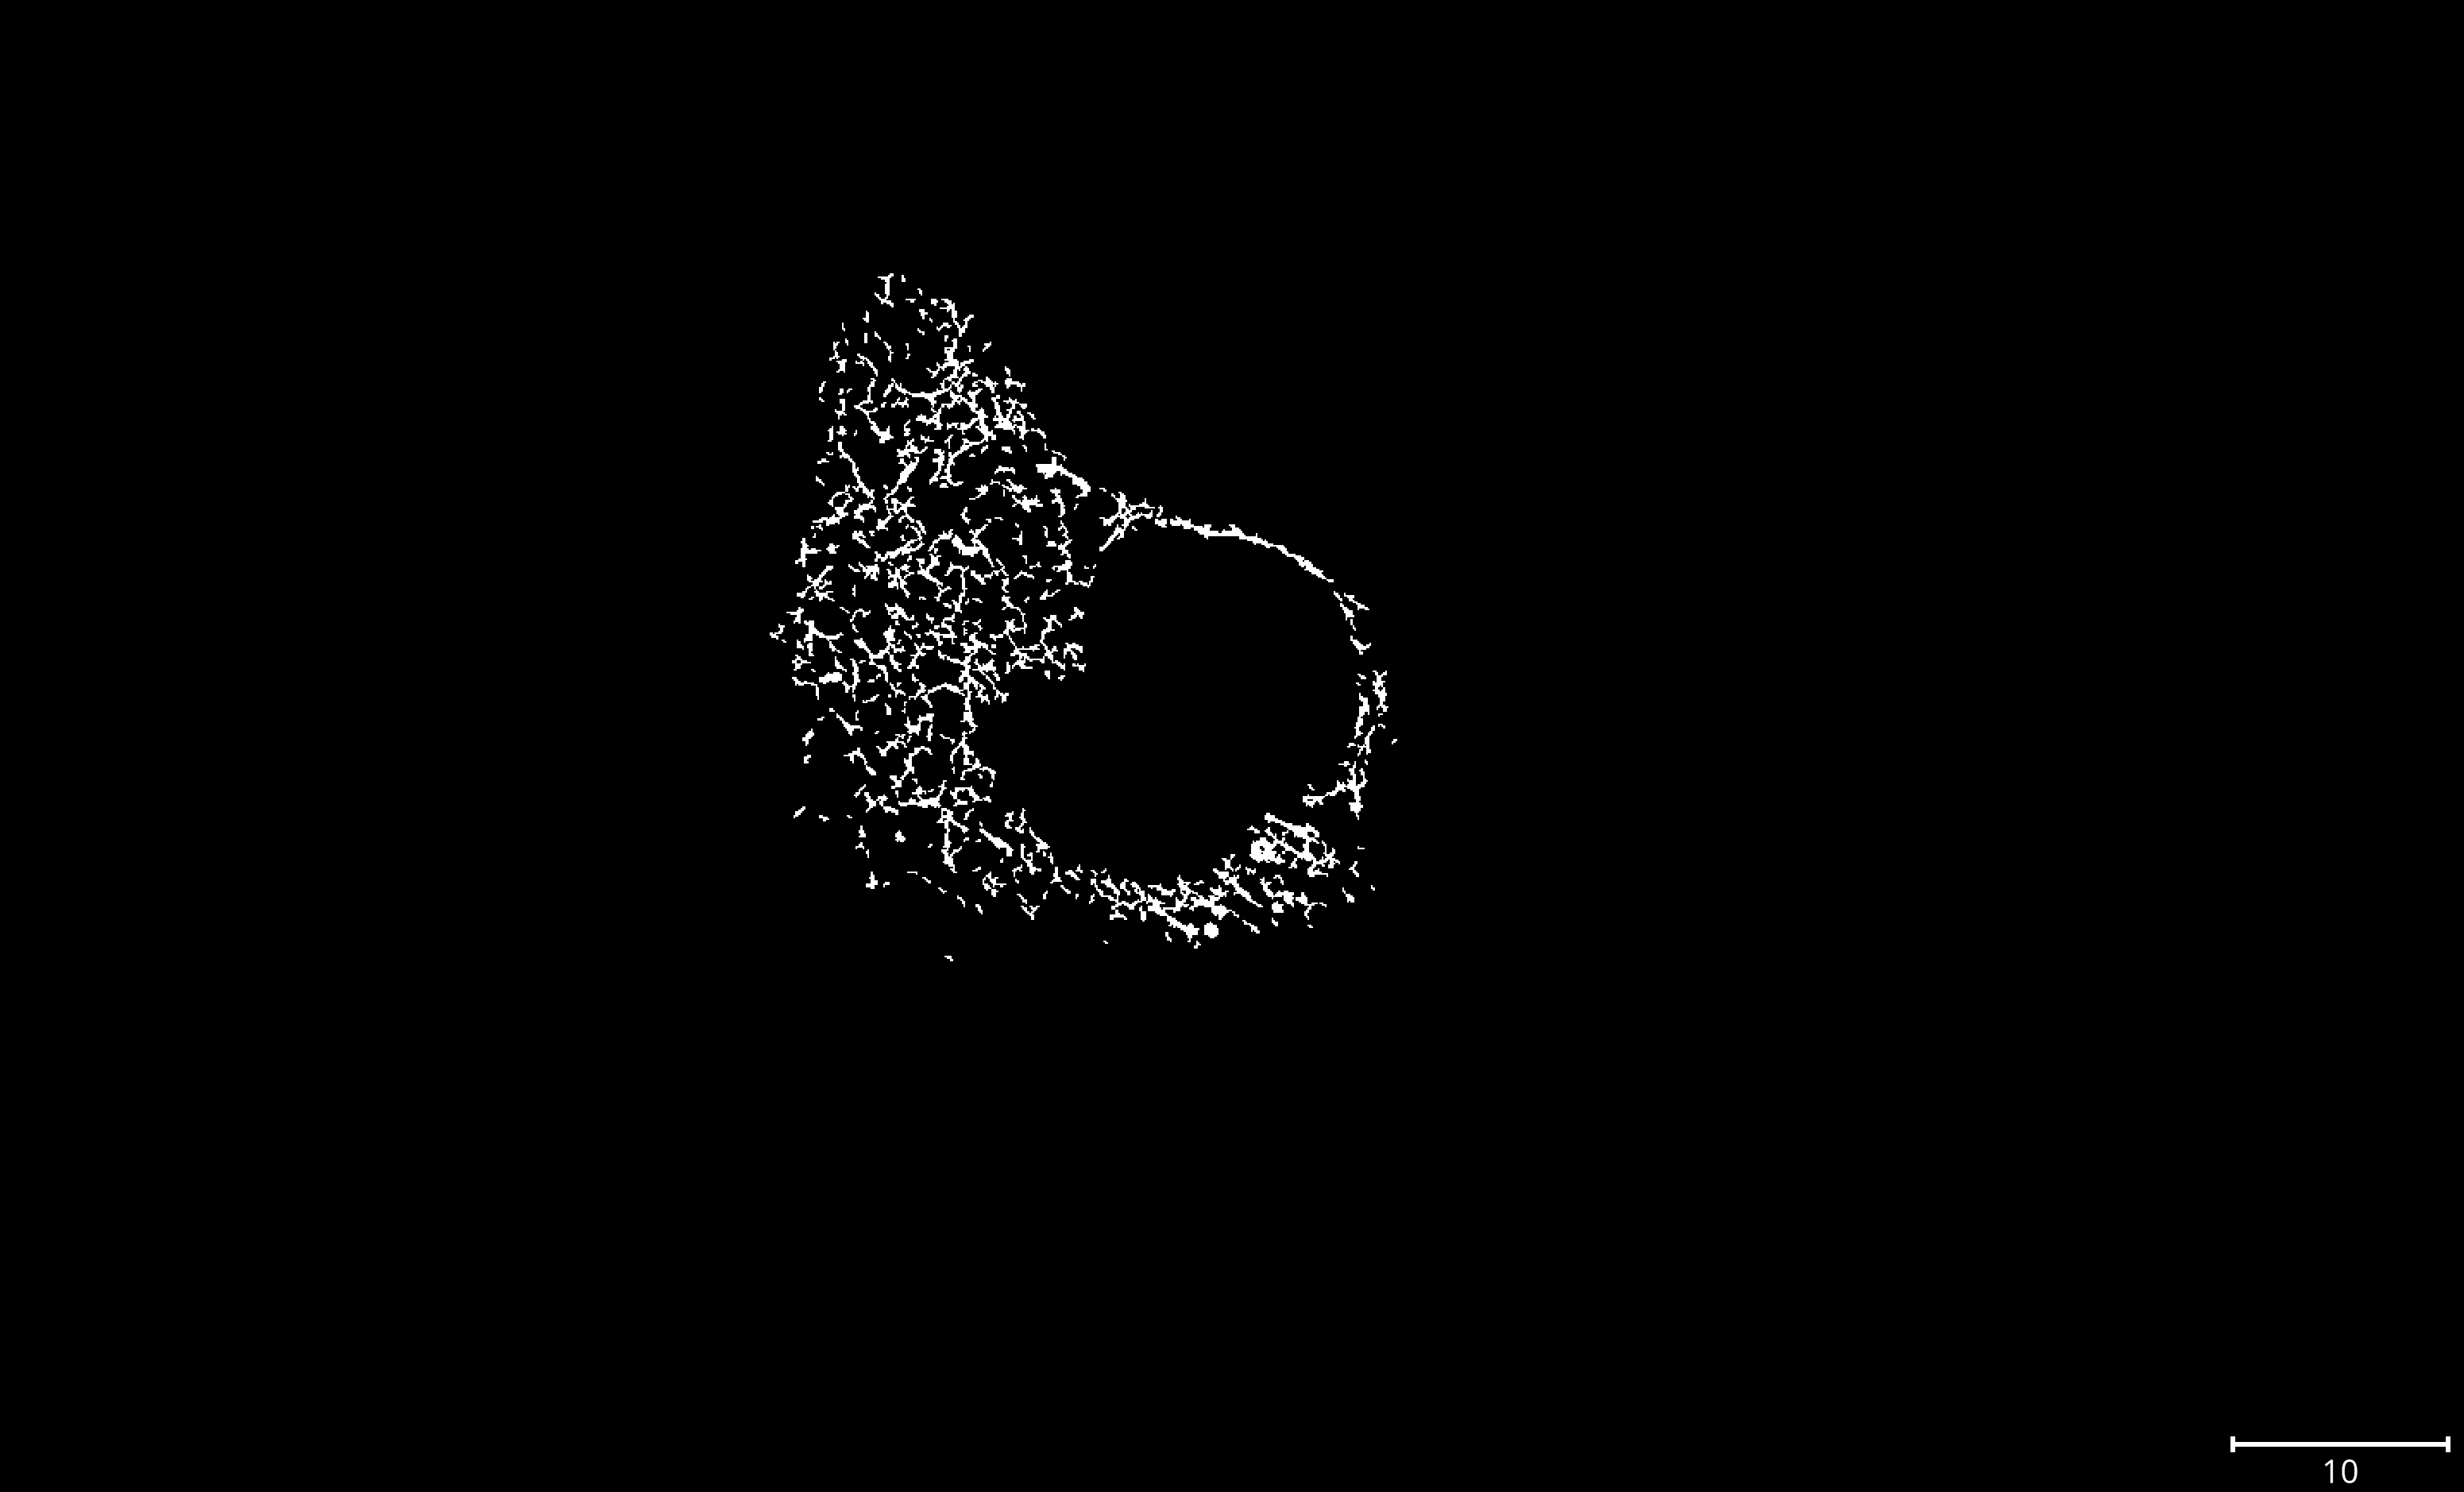

In [20]:
from napari.utils.notebook_display import nbscreenshot

# viewer.dims.ndisplay = 3
# viewer.camera.angles = (-30, 25, 120)
nbscreenshot(viewer, canvas_only=True)

In [11]:
from infer_subc_2d.organelles_config.helper import add_function_spec_to_widget_json

_fixed_infer_er =  {
        "name": "infer endoplasmic reticulum  (fixed parameters)",
        "python::module": "infer_subc_2d.organelles",
        "python::function": "fixed_infer_endoplasmic_reticulum",
        "parameters": None
        }

add_function_spec_to_widget_json("fixed_infer_er",_fixed_infer_er)

function fixed_infer_er is already in all_functions.json


0

In [12]:

_infer_er =  {
        "name": "Infer Endoplasmic Reticulum",
        "python::module": "infer_subc_2d.organelles",
        "python::function": "infer_endoplasmic_reticulum",
        "parameters": {
                "filament_scale": {
                        "data_type": "float",
                        "increment": 0.05,
                        "max": 10,
                        "min": 0,
                        "widget_type": "slider"
                },
                "filament_cut": {
                        "data_type": "float",
                        "increment": 0.001,
                        "max": 0.5,
                        "min": 0,
                        "widget_type": "slider"
                },
                "small_obj_w": {
                        "data_type": "int",
                        "increment": 1,
                        "max": 50,
                        "min": 1,
                        "widget_type": "slider"
                }
        }
}

add_function_spec_to_widget_json("infer_er", _infer_er, overwrite=True )



function infer_er is already in all_functions.json
overwriting  infer_er


1

In [10]:

_filament_filter =  {
        "name": "filament filter thresholding",
        "python::module": "infer_subc_2d.utils.img",
        "python::function": "filament_filter",
        "parameters": {
                "filament_scale": {
                        "data_type": "float",
                        "increment": 0.05,
                        "max": 10,
                        "min": 0,
                        "widget_type": "slider"
                },
                "filament_cut": {
                        "data_type": "float",
                        "increment": 0.001,
                        "max": 0.5,
                        "min": 0,
                        "widget_type": "slider"
                },
        }
}

add_function_spec_to_widget_json("filament_filter", _filament_filter, overwrite=True )



1

In [5]:
from infer_subc_2d.constants import ER_CH
def make_infer_er_step_by_step_from_raw_dict():
    """
    Procedure to infer mitochondria from linearly unmixed input from raw

    """
    step_name = []
    function_name = []
    category =[]
    parameter_values = []
    parent = []
   
    ###################
    # EXTRACT
    ###################   
    step_name = []
    function_name = []
    category =[]
    parameter_values = []
    parent = []
   
    ###################
    # EXTRACT
    ###################   

    step_name.append("1")
    function_name.append("fixed_get_optimal_Z_img")
    category.append("extraction")
    parameter_values.append(None)
    parent.append(0)

    step_name.append("2")
    function_name.append("fixed_infer_soma")
    category.append("extraction")
    parameter_values.append( None )
    parent.append(1)

    step_name.append("3")
    function_name.append("fixed_infer_nuclei")
    category.append("extraction")
    parameter_values.append( None )
    parent.append([1,2])

    step_name.append("4")
    function_name.append("infer_cytosol")
    category.append("extraction")
    parameter_values.append(dict(erode_nuclei = True ))
    parent.append([2,3])

    step_name.append("5")
    function_name.append("select_channel_from_raw")
    category.append("extraction")
    parameter_values.append( dict(chan = ER_CH) )
    parent.append(1)
    
    step_name.append("6")
    function_name.append("min_max_intensity_normalization")
    category.append("preprocessing")
    parameter_values.append(None)
    parent.append(5)

    step_name.append("7")
    function_name.append("edge_preserving_smoothing")
    category.append("preprocessing")
    parameter_values.append(None)
    parent.append(6)

    step_name.append("8")
    function_name.append("filament_filter") 
    category.append("core")
    parameter_values.append( dict( filament_scale=1., filament_cut=.15) )
    parent.append(7)

    step_name.append("9")
    function_name.append("apply_mask")
    category.append("postprocessing")
    parameter_values.append(None)
    parent.append([8,4])

    step_name.append("10")
    function_name.append("size_filter_2D")
    category.append("postprocessing")
    parameter_values.append(dict( min_size = 2**2  ))
    parent.append(9)

    out_dict = dict()
    for i,stepn in enumerate(step_name):
        entry = dict(category=category[i],
                            function=function_name[i],
                            parameter_values=parameter_values[i],
                            parent=parent[i]
        )
        if entry['parameter_values'] is None:
            _ = entry.pop('parameter_values')
        out_dict[stepn] = entry
    
    return out_dict



In [6]:
from infer_subc_2d.organelles_config.helper import write_workflow_json

infer_er_stepbystep_from_raw_dict = make_infer_er_step_by_step_from_raw_dict()

write_workflow_json("conf_infer_er_from_raw", infer_er_stepbystep_from_raw_dict)

PosixPath('/Users/ahenrie/Projects/Imaging/infer-subc-2D/infer_subc_2d/organelles_config/conf_infer_er_from_raw.json')

---------------------

 🚧 WIP 🚧 (🚨🚨🚨🚨 )

# WORKFLOW #2 (WIP)
as per 6/22 CellProfiler pipeline from MCZ
 
## summary of steps

INPUT
- ch 6
- CY mask

PRE-PROCESSING
- rescale 
- median window:4
- non-local noise reduction
  - size:5, distance:1, cut-off:0.1
- identify "TUBES"
  - enhance neurites
    - > Neurites: Neurites are taken to be long, thin features of enhanced intensity. Choose this option to enhance the intensity of the neurites using the Line structures or Tubeness methods described in a later setting.  
    - method: tubeness
    - > Tubeness: This method is an adaptation of the method used by the ImageJ Tubeness plugin. The image is smoothed with a Gaussian. The Hessian is then computed at every point to measure the intensity gradient and the eigenvalues of the Hessian are computed to determine the magnitude of the intensity. The absolute maximum of the two eigenvalues gives a measure of the ratio of the intensity of the gradient in the direction of its most rapid descent versus in the orthogonal direction. The output image is the absolute magnitude of the highest eigenvalue if that eigenvalue is negative (white neurite on dark background), otherwise, zero. 
    - smoothing: 2 pix

CORE-PROCESSING
- identify primary objects "TUBES"
    - adaptive Sauvola
      - threshold smoothing scale: 0
      - threshold correction factor: .6
      - threshold bounds: (0. ,1.0)
      - adaptive window: 20 pixels
- identify primary objects "SHEETS"
  - ER masked w/ CY
  - adaptive Otsu
      - diameter: (2,50)
    - two classes
      - threshold smoothing scale: 0
      - threshold correction factor: 1
      - threshold bounds: (0.18, .25)
      - adaptive window: 10 pixels
- combine "TUBES" and "SHEETS"



OUTPUT
- object ER




### INPUT

In [ ]:

###################
# INPUT
###################
struct_img_raw = img_data[5,:,:,:].copy()

# DEFAULT PARAMETERS:
intensity_norm_param = [3.5, 15] # from Allen Cell Segmenter LAMP1  workflow
scaling_param = [0]
gaussian_smoothing_sigma = 1.
gaussian_smoothing_truncate_range = 3.0
dot_2d_sigma = 2
dot_2d_sigma_extra = 1
dot_2d_cutoff = 0.025
min_area = 10
low_level_min_size =  100

med_filter_size =2  

gaussian_smoothing_sigma = 10
gaussian_smoothing_truncate_range = 3.0

aicssegmentation.core.pre_processing_utils.suggest_normalization_param(struct_img_raw) #  [0., 23]


### PRE-PROCESSING

In [ ]:
###################
# PRE_PROCESSING
###################

intensity_norm_param = [0] # 

# Linear-ish smoothing
raw_mito = intensity_normalization( struct_img_raw ,  scaling_param=intensity_norm_param)

med_filter_size =3  

gaussian_smoothing_sigma = 1.3
gaussian_smoothing_truncate_range = 3.0

struct_img = median_filter(raw_mito,    size=med_filter_size  )

structure_img_smooth = image_smoothing_gaussian_3d(   struct_img,
                                                                                                                        sigma=gaussian_smoothing_sigma,
                                                                                                                        truncate_range=gaussian_smoothing_truncate_range,
                                                                                                                    )


# log_img, d = log_transform( structure_img_smooth ) 
# struct_img = intensity_normalization(  log_img  ,  scaling_param=[0] )  

struct_img = structure_img_smooth

### CORE PROCESSING

In [ ]:
# enhance spreckles - 40
big_struct_rad = 40
big_img = _enhance_speckles(struct_img.copy(),big_struct_rad, True)



In [ ]:

# enhance spreckles - 10
sm_struct_rad = 20
sm_img = _enhance_speckles(struct_img.copy(),sm_struct_rad, True)


#adaptive_otsu(big_struct) # three class - middle foreground
# adaptive window- 20
#size: 10,100
# threshold smooth 1.34
# threshold correction 1
# threshold (0.1497,1)
#fill holes
# "adatpive" thresholds are NOT currently working... will use      
# "Masked Object Thresholding" - 3D
low_level_min_size = 10
bw_big, _bw_low_level = MO(big_img, 
                                                global_thresh_method='ave', 
                                                object_minArea=low_level_min_size, 
                                                extra_criteria=True,
                                                local_adjust= 0.5, 
                                                return_object=True,
                                                dilate=True)
 # or this?                                               
#    struct_obj = struct_img > filters.threshold_otsu(struct_img)
#     threshold_value_log = threshold_otsu_log(struct_img)

#     thresh_factor = 0.9 #from cellProfiler
#     thresh_min = .1
#     thresh_max = 1.
#     threshold = min( max(threshold_value_log*thresh_factor, thresh_min), thresh_max)
#     struct_obj = struct_img > threshold


# enhance speckles
#   adaptive_sauvola(sm_struct) 
# adaptive window- 10
#size: 2,10
# threshold smooth 1.34
# threshold correction 1
# threshold (0.05,1)
#fill holes
# "adatpive" thresholds are NOT currently working... will use      
# "Masked Object Thresholding" - 3D
low_level_min_size = 2
bw_sm, _bw_low_level = MO(sm_img, 
                                                global_thresh_method='ave', 
                                                object_minArea=low_level_min_size, 
                                                extra_criteria=True,
                                                local_adjust= 0.5, 
                                                return_object=True,
                                                dilate=True)
 # or this?                                               
#    struct_obj = struct_img > filters.threshold_otsu(struct_img)
#     threshold_value_log = threshold_otsu_log(struct_img)
#     thresh_factor = 0.9 #from cellProfiler
#     thresh_min = .1
#     thresh_max = 1.
#     threshold = min( max(threshold_value_log*thresh_factor, thresh_min), thresh_max)
#     struct_obj = struct_img > threshold



### POST-PROCESSING

In [ ]:
###################
# POST_PROCESSING
###################


# 3D
# cleaned_img = remove_small_objects(removed_holes>0, 
#                                                             min_size=minArea, 
#                                                             connectivity=1, 
#                                                             in_place=False)
small_object_width = 10
cleaned_img_big = size_filter(bw_big, # wrapper to remove_small_objects which can do slice by slice
                                                         min_size= small_object_width**2,
                                                         method = "slice_by_slice",
                                                         connectivity=1)


#                                                             in_place=False)
small_object_width = 2
cleaned_img_sm = size_filter(bw_sm, # wrapper to remove_small_objects which can do slice by slice
                                                         min_size= small_object_width**2,
                                                         method = "slice_by_slice",
                                                         connectivity=1)



cleaned_img = np.logical_or(cleaned_img_big, cleaned_img_sm)



#### Visualize with `napari`
Visualize the first-pass segmentation and labeling with `napari`.

In [ ]:

if viewer is None:
    viewer = napari.view_image(
        cleaned_img,
        scale=scale
    )
else: 
    viewer.add_image(
        cleaned_img,
        scale=scale
    )

viewer.scale_bar.visible = True
viewer.add_image(
    cleaned_img_big,
    scale=scale
)

viewer.add_image(
    big_img,
    scale=scale
)
viewer.add_image(
    cleaned_img_big,
    scale=scale
)
viewer.add_image(
    sm_img,
    scale=scale
)